## Load Data

The h5 file contains three component: 

1. raw audio data

2. label (direction of arrival)

3. stft (short time fourier transform for 100ms split)

In [1]:
import h5py
import numpy as np

# Path to the H5 file
h5_file_path = r"C:\Users\grizi\Desktop\TUD\year2\thesis\neural_network\data_preparation_acoular\data_generator\simulation_data.h5"

# Open the H5 file
with h5py.File(h5_file_path, 'r') as h5file:
    # Load datasets
    audio_data = np.array(h5file['audio'])
    angles = np.array(h5file['position'])
    stft_data = np.array(h5file['stft'])

    # Print dataset shapes
    print(f"Audio shape: {audio_data.shape}")
    print(f"Position shape: {angles.shape}")
    print(f"STFT shape: {stft_data.shape}")

# check the data from the simulation is not bad 
a = audio_data[0,0]
b = audio_data[10,0]
if np.array_equal(a, b):  
    print("Equal")
else:
    print("Not Equal")

Audio shape: (180, 4410, 32)
Position shape: (180,)
STFT shape: (180, 64, 183, 7)
Not Equal


## Label Encoding 

Encode the label to a Gaussian Distribution 

In [2]:
def generate_gaussian(center, start, end, peak_value=1, sigma=1):

    x = np.arange(start, end + 1)  # Generate the range from start to end
    gaussian = np.exp(-0.5 * ((x - center) ** 2) / (sigma ** 2))  # Gaussian formula
    gaussian = gaussian / gaussian.max() * peak_value  # Normalize to make the peak value equal to `peak_value`
    return gaussian

# Generate Gaussian distribution from 1 to 11 with peak at 6
start, end, center = 1, 31, 15
sigma = 2  # Standard deviation
gaussian_distribution = generate_gaussian(center, start, end, peak_value=1, sigma=sigma)

gaussian_distribution

array([2.28973485e-11, 6.69158609e-10, 1.52299797e-08, 2.69957850e-07,
       3.72665317e-06, 4.00652974e-05, 3.35462628e-04, 2.18749112e-03,
       1.11089965e-02, 4.39369336e-02, 1.35335283e-01, 3.24652467e-01,
       6.06530660e-01, 8.82496903e-01, 1.00000000e+00, 8.82496903e-01,
       6.06530660e-01, 3.24652467e-01, 1.35335283e-01, 4.39369336e-02,
       1.11089965e-02, 2.18749112e-03, 3.35462628e-04, 4.00652974e-05,
       3.72665317e-06, 2.69957850e-07, 1.52299797e-08, 6.69158609e-10,
       2.28973485e-11, 6.10193668e-13, 1.26641655e-14])

In [4]:
zero_matrix_train = np.zeros((len(angles),360))

# Define the Gaussian distribution function
def gaussian_labeling(label, num_classes=360):

    zero_row = np.zeros((num_classes))
    for i in range(31):
        center = label + i - 15
        if center < 0:
            center = 360 + center
        elif center > 359:
            center = center - 360
        zero_row[center] = gaussian_distribution[i]*20

    return zero_row

    

# set the method for encoding the labels
encode_method = "gaussian"

# encode the labels as a gaussian distribution
possibility_matrix_angle = zero_matrix_train

for i in range(len(angles)):
    ground_truth_angle = int(angles[i])  # Ground truth angle
    possibility_matrix_angle[i,:] = gaussian_labeling(ground_truth_angle, 360)


# possibility_matrix now contains the Gaussian-encoded labels
print(possibility_matrix_angle.shape)
print(np.argmax(possibility_matrix_angle[3]))


(180, 360)
5


Now we want to make a random sequence (label and audio_data)

In [5]:
# Generate random indices
shuffle_indices = np.random.permutation(possibility_matrix_angle.shape[0])

# Shuffle both matrices based on the random indices
possibility_matrix_angle = possibility_matrix_angle[shuffle_indices]
stft = stft_data[shuffle_indices]

stft = stft.reshape((180,64,7,183))

In [6]:
angles_shift = angles[shuffle_indices]
print(angles_shift)

[328. 146.  92. 324.  88. 272. 292.  64.  72. 124.  10. 356.  48. 142.
  18. 274. 184. 130.  32. 326. 174. 198.  54.  50. 334. 114.  96. 244.
  62. 288.  94. 122.  68. 202.  82. 358. 252.  28. 278.   4. 270. 260.
  12. 312. 342. 346. 330.  60. 290.  56. 196. 206. 264.   6. 118. 340.
 308.  16.  76. 218. 100.  26. 158. 238. 126.  84. 144. 228. 304. 258.
 164. 354.  74.  42. 248.  40. 128. 320. 180.  22.   0. 138. 230. 208.
 154. 314. 282.  38. 350. 168. 316. 240. 298. 176.  34. 332. 344. 102.
 110. 232.  66.  46. 140.  52. 310. 182. 160. 216. 286. 224. 280. 162.
 318.  30. 170. 262. 212. 166. 190. 236. 104. 294.  86. 302. 172. 276.
 148. 188. 204. 178. 112. 322. 246. 214. 134. 268. 352. 348. 250. 336.
 254. 200. 296. 156. 152. 234.  44.  80. 192.  78. 120. 150. 106. 226.
 210. 242. 194. 306. 136. 108.  20. 284.   8.   2.  90.  98. 338. 220.
  58. 266.  24. 256. 222. 300.  36.  70. 116. 186.  14. 132.]


## Model Construction

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual  # Shortcut connection
        out = F.relu(out)
        return out

class DOA_Network(nn.Module):
    def __init__(self, input_channels=64, time_steps=7, doa_bins=360):
        super(DOA_Network, self).__init__()
        
        # 1x7 Convolution, stride (1,3), output channels 32
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=128, kernel_size=(1, 7), stride=(1, 2))
        self.bn1 = nn.BatchNorm2d(128)
        
        # 1x5 Convolution, stride (1,2), output channels 128
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1, 5), stride=(1, 2))
        self.bn2 = nn.BatchNorm2d(256)
        
        # 5 Residual Blocks
        self.res_blocks = nn.Sequential(*[ResidualBlock(256) for _ in range(5)])
        
        # 1x1 Convolution, output channels 360 (DOA bins)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=doa_bins, kernel_size=(1, 1))
        self.bn3 = nn.BatchNorm2d(doa_bins)
        
        # 1x1 Convolution, output channels 500
        self.conv4 = nn.Conv2d(in_channels=43, out_channels=500, kernel_size=(1, 1))
        self.bn4 = nn.BatchNorm2d(500)
        
        # 7x5 Convolution, output channels 1 (Final Spatial Spectrum Output)
        self.conv5 = nn.Conv2d(in_channels=500, out_channels=1, kernel_size=(7, 5), padding=(0, 2))
        
        # A MLP layer to handle the 360 vector
        self.fc = nn.Linear(360, 360)
        
    def forward(self, x):
        # Initial convolutions
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))

        
        # Residual blocks
        x = self.res_blocks(x)
  
        
        # 1x1 Convolution to DOA bins
        x = F.relu(self.bn3(self.conv3(x)))
        
        # Swap axes (B, T, DOA, F) -> (B, T, F, DOA)
        stage1_x = x
        x = x.permute(0, 3, 2, 1) 
        
        # 1x1 Convolution
        x = F.relu(self.bn4(self.conv4(x)))
        
        # Final 7x5 Convolution with Sigmoid activation
        x = torch.sigmoid(self.conv5(x))
        
        # Remove channel dimension and return (B, T, DOA)
        x = x.squeeze(1).squeeze(1)
        return x, stage1_x

# Example usage
if __name__ == "__main__":
    # Define input dimensions (Batch, Channels, Time, Frequency)
    batch_size = 4
    input_tensor = torch.randn(batch_size, 64, 7, 183)  # (B, C, T, F)
    
    model = DOA_Network()
    output,xx = model(input_tensor)
    print("Output shape:", output.shape)  # Expected: (B, T, 360)


Output shape: torch.Size([4, 360])


## Loss Function Definition

First we define a loss function for the first training stage, then we have to ensure that the loss function has a gradient that could be used in the backward session.

In [84]:
import torch 
class Stage1_loss(nn.Module):
    def __init__(self):
        super(Stage1_loss, self).__init__()
        self.mse = nn.MSELoss(reduction='none')  # Calculate MSE loss without reduction

    def forward(self, y_pred, y_true):
        """
        Compute Stage1 Loss:
        1. Calculate MSE loss for each element in the (7, 25) region.
        2. Average the loss over the (7, 25) region.
        3. Average the loss over all samples and all feature dimensions to get a scalar loss.

        Parameters:
        - y_pred: (batch_size, 360, 7, 25) - Predicted tensor
        - y_true: (batch_size, 360) - Ground truth tensor

        Returns:
        - final_loss: Scalar loss value
        """
        
        # Expand y_true to match y_pred shape (batch_size, 360, 7, 25)
        y_true_expanded = y_true.unsqueeze(-1).unsqueeze(-1)  # (4, 360, 1, 1)

        # Calculate MSE loss element-wise: result shape -> (batch_size, 360, 7, 25)
        loss = self.mse(y_pred, y_true_expanded)

        # Compute the mean loss over the last two dimensions (7, 25) -> (batch_size, 360)
        loss_mean_per_feature = loss.mean(dim=(-1, -2))

        # Compute the mean loss over all samples and features -> scalar
        final_loss = loss_mean_per_feature.mean()

        return final_loss


# Instantiate the loss function
loss_fn = Stage1_loss()
y_pred = torch.randn((4, 360, 7, 25),requires_grad=True)  # Random prediction
y_true = torch.randn(4, 360)  # Random ground truth

# Compute the loss
loss = loss_fn(y_pred, y_true)

print("Loss:", loss.item())

# Attempt backpropagation
loss.backward()  # Should work correctly
print("Backward successful!")

Loss: 2.0273120403289795
Backward successful!


## Training 

### Training Stage 1

In this part, our goal is to train the intermediate representation of shape (360, 7, 25) to approximate a (1, 360) vector that encodes directional information. From my understanding, training on a larger, more detailed intermediate representation first can simplify the learning process, making it easier for the neural network to converge compared to directly training the final (1, 360) output.

(180, 64, 7, 183)


c:\Users\grizi\anaconda3\envs\dt-test\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4, 360, 1, 1])) that is different to the input size (torch.Size([4, 360, 7, 43])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch : 0, set : 2/45, loss : 4.2757391929626465
Epoch : 0, set : 3/45, loss : 3.986983060836792
Epoch : 0, set : 4/45, loss : 3.9293508529663086
Epoch : 0, set : 5/45, loss : 3.929222345352173
Epoch : 0, set : 6/45, loss : 3.893608808517456
Epoch : 0, set : 7/45, loss : 3.901731491088867
Epoch : 0, set : 8/45, loss : 3.8968052864074707
Epoch : 0, set : 9/45, loss : 3.9317173957824707
Epoch : 0, set : 10/45, loss : 3.8935279846191406
Epoch : 0, set : 11/45, loss : 3.9279396533966064
Epoch : 0, set : 12/45, loss : 3.9293899536132812
Epoch : 0, set : 13/45, loss : 3.910815477371216
Epoch : 0, set : 14/45, loss : 3.905313491821289
Epoch : 0, set : 15/45, loss : 3.913904905319214
Epoch : 0, set : 16/45, loss : 3.8899924755096436
Epoch : 0, set : 17/45, loss : 3.9215664863586426
Epoch : 0, set : 18/45, loss : 3.937828302383423
Epoch : 0, set : 19/45, loss : 3.8863167762756348
Epoch : 0, set : 20/45, loss : 3.9022469520568848
Epoch : 0, set : 21/45, loss : 3.919761896133423
Epoch : 0, set : 

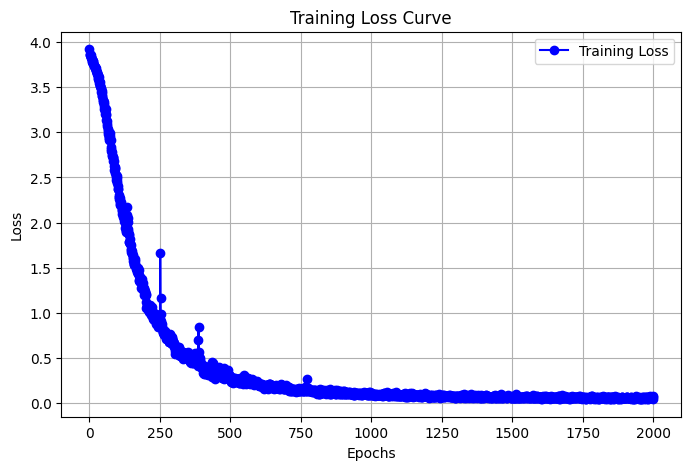

Model weights saved to C:\Users\grizi\Desktop\TUD\year2\thesis\neural_network\DoA_Net\model\DOA_Network_stage1.pth


In [113]:
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    
# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    loss_history = []  # Store loss for each epoch
    
    for epoch in range(num_epochs):
        total_loss = 0
        index = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs,stage1 = model(inputs)
            # print(stage1[0,:,0,0])
            loss = criterion(stage1, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            index += 1
            print(f"Epoch : {epoch}, set : {index+1}/{len(train_loader)}, loss : {loss}")
        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)

        scheduler.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
    # Plot training curve
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), loss_history, marker='o', linestyle='-', color='b', label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid()
    plt.show()

# Prediction function
def predict(model, input_tensor, device):
    model.eval()
    with torch.no_grad():
        input_tensor = input_tensor.to(device)
        output = model(input_tensor)
    return output.cpu()

# Example usage
if __name__ == "__main__":
    # Define input dimensions (Batch, Channels, Time, Frequency)
    batch_size = 4
    print(stft.shape)
    input_tensor = torch.from_numpy(stft[:,:,:,:]).float()
    target_tensor = torch.from_numpy(possibility_matrix_angle[:,:]).float()
    
    # Create dataset and dataloader
    dataset = CustomDataset(input_tensor, target_tensor)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model, loss function, and optimizer

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # torch.cuda.set_per_process_memory_fraction(0.6, device=device)

    model = DOA_Network().to(device)
    criterion = Stage1_loss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = StepLR(optimizer, step_size=100, gamma=0.8)
    
    # Train the model
    train_model(model, train_loader, criterion, optimizer, num_epochs=2000)



# save the weight of the model
model_save_path = r"C:\Users\grizi\Desktop\TUD\year2\thesis\neural_network\DoA_Net\model\DOA_Network_stage1.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")



### Training Stage 2

In the second training phase, based on the previously trained model, we use the MSE loss to measure the difference between the model's output (1, 360) and the corresponding label (1, 360).

In [116]:
# Training function for continued training
def stage2_training(model, train_loader, criterion, optimizer, device, num_epochs=1):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            # Forward pass with the model
            outputs, stage1 = model(inputs)

            # Compute loss using Stage 1 outputs
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            scheduler.step()

            # Print progress
            print(f"Epoch: {epoch}, Batch: {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

        # Print average loss per epoch
        print(f"Epoch [{epoch}/{num_epochs}], Average Loss: {total_loss / len(train_loader):.4f}")

    print("stage2 training completed.")

# set the MSEloss as the criterion for the stage 2 training
criterion = nn.MSELoss()

# set the epoch for the second stage
num_epochs = 20

# freeze the layers which does not need training 
for name, param in model.named_parameters():
    if not any(layer in name for layer in ["conv4", "bn4", "conv5","fc"]):  
        param.requires_grad = False  

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

# load the model weights from stage 1
model_stage1 = r"C:\Users\grizi\Desktop\TUD\year2\thesis\neural_network\DoA_Net\model\DOA_Network_stage1.pth"
model.load_state_dict(torch.load(model_stage1, map_location=device))

# Continue training the model
stage2_training(model, train_loader, criterion, optimizer, device, num_epochs)

# save the weight of the model
model_save_path = r"C:\Users\grizi\Desktop\TUD\year2\thesis\neural_network\DoA_Net\model\DOA_Network_stage2.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")


Epoch: 0, Batch: 1/45, Loss: 4.0468
Epoch: 0, Batch: 2/45, Loss: 3.4815
Epoch: 0, Batch: 3/45, Loss: 3.4302
Epoch: 0, Batch: 4/45, Loss: 3.4210
Epoch: 0, Batch: 5/45, Loss: 3.4205
Epoch: 0, Batch: 6/45, Loss: 3.4190
Epoch: 0, Batch: 7/45, Loss: 3.4188
Epoch: 0, Batch: 8/45, Loss: 3.4179
Epoch: 0, Batch: 9/45, Loss: 3.4188
Epoch: 0, Batch: 10/45, Loss: 3.4185
Epoch: 0, Batch: 11/45, Loss: 3.4186
Epoch: 0, Batch: 12/45, Loss: 3.4184
Epoch: 0, Batch: 13/45, Loss: 3.4183
Epoch: 0, Batch: 14/45, Loss: 3.4182
Epoch: 0, Batch: 15/45, Loss: 3.4178
Epoch: 0, Batch: 16/45, Loss: 3.4183
Epoch: 0, Batch: 17/45, Loss: 3.4181
Epoch: 0, Batch: 18/45, Loss: 3.4181
Epoch: 0, Batch: 19/45, Loss: 3.4181
Epoch: 0, Batch: 20/45, Loss: 3.4180
Epoch: 0, Batch: 21/45, Loss: 3.4181
Epoch: 0, Batch: 22/45, Loss: 3.4185
Epoch: 0, Batch: 23/45, Loss: 3.4181
Epoch: 0, Batch: 24/45, Loss: 3.4175
Epoch: 0, Batch: 25/45, Loss: 3.4182
Epoch: 0, Batch: 26/45, Loss: 3.4179
Epoch: 0, Batch: 27/45, Loss: 3.4181
Epoch: 0, 

### Testing 

First we need to define a new prediction function for our model which has two output (intermediate output and final output)

In [117]:
def predict(model, input_tensor, device):
    model.eval()
    with torch.no_grad():
        input_tensor = input_tensor.to(device)
        output, stage1_output = model(input_tensor)  # Unpack the tuple
    return output.cpu(), stage1_output.cpu()  # Apply .cpu() to each tensor


In [ ]:
print(input_tensor.shape)
print(target_tensor.shape)

errors = 0

for k in range(len(input_tensor)):
    test_input = input_tensor[k:k+1,:,:,:]
    prediction, stage1_output = predict(model, test_input, device)
    angle_pre = 0
    for i in range (stage1_output.shape[2]):
        for j in range (stage1_output.shape[3]):
            angle_pre += torch.argmax(stage1_output[0,:,i,j]).item()

    angle_pre = angle_pre/ (stage1_output.shape[2]*stage1_output.shape[3])
    print("The average angle of the parameter is",angle_pre)

    row = prediction[0, :]
    max_value = torch.max(row).item()  
    max_indices = torch.where(row == max_value)[0].tolist() 
    final_prediction =  np.mean(max_indices)

    print(f"Final prediction: {final_prediction}")
    print(f"Indices of maximum value: {max_indices}")

    label = torch.argmax(target_tensor[k,:]).item()
    

    error = abs(final_prediction - label)
    if error > 180:
        error = 360 - error
    errors += error
    print(f"Label: {label} error: {error}")
    


print(f"The average error: {errors/len(input_tensor)}")



torch.Size([180, 64, 7, 183])
torch.Size([180, 360])
The average angle of the parameter is 249.85382059800665
Final prediction: 326.0
Indices of maximum value: [325, 326, 327]
Label: 327 error: 1.0
The average angle of the parameter is 108.34883720930233
Final prediction: 146.0
Indices of maximum value: [146]
Label: 145 error: 1.0
The average angle of the parameter is 222.2358803986711
Final prediction: 261.0
Indices of maximum value: [261]
Label: 91 error: 170.0
The average angle of the parameter is 233.46179401993356
Final prediction: 321.0
Indices of maximum value: [320, 321, 322]
Label: 322 error: 1.0
The average angle of the parameter is 181.7109634551495
Final prediction: 261.0
Indices of maximum value: [261]
Label: 87 error: 174.0
The average angle of the parameter is 284.8272425249169
Final prediction: 271.0
Indices of maximum value: [271]
Label: 271 error: 0.0
The average angle of the parameter is 276.51827242524917
Final prediction: 292.5
Indices of maximum value: [291, 292, 

In [113]:
# Prediction example
print(input_tensor.shape)
test_input = input_tensor[1:2,:,:,:]
prediction, stage1_output = predict(model, test_input, device)
print("Prediction shape:", prediction.shape)
print(prediction.shape)


# Calculate the average angle of the intermediate predicted tensor
angle_pre = 0
for i in range (stage1_output.shape[2]):
    for j in range (stage1_output.shape[3]):
        angle_pre += torch.argmax(stage1_output[0,:,i,j]).item()

angle_pre = angle_pre/ (stage1_output.shape[2]*stage1_output.shape[3])
print("The average angle of the parameter is",angle_pre)


max_intermediate = torch.argmax(stage1_output[0,:,3,0]).item()
max_index = torch.argmax(prediction[0,:]).item()
print(f"The prediction from the final layer: {max_index}")

# print the ground truth
max_index = torch.argmax(target_tensor[1,:]).item()
print(f"Label: {max_index}")

torch.Size([5, 64, 7, 183])
Prediction shape: torch.Size([1, 360])
torch.Size([1, 360])
The average angle of the parameter is 98.49169435215947
The prediction from the final layer: 39
Label: 155


In [127]:
# check the error for all the input tensor
print(input_tensor.shape)
print(target_tensor.shape)
for k in range(len(input_tensor)):
    test_input = input_tensor[k:k+1,:,:,:]
    prediction, stage1_output = predict(model, test_input, device)
    angle_pre = 0
    for i in range (stage1_output.shape[2]):
        for j in range (stage1_output.shape[3]):
            
            angle_pre += torch.argmax(stage1_output[0,:,i,j]).item()
            print(angle_pre)
    # print(stage1_output[0,:,0,0])
    # print(torch.argmax(stage1_output[0,:,0,0]))

    angle_pre = angle_pre/ (stage1_output.shape[2]*stage1_output.shape[3])
    print("The average angle of the parameter is",angle_pre)
    print(prediction.shape)
    max_index = torch.argmax(prediction[0,:]).item()
    print(f"The prediction from the final layer: {max_index}")

    label = torch.argmax(target_tensor[k,:]).item()
    print(f"Label: {label}")

torch.Size([2, 64, 7, 183])
torch.Size([2, 360])
351
702
1053
1404
1755
2106
2168
2519
2870
3221
3572
3923
4274
4625
4976
5327
5678
5740
5803
5866
5930
5992
6055
6117
6181
6245
6596
6947
7298
7649
8000
8351
8702
9053
9404
9755
10106
10457
10808
11159
11510
11861
12212
12563
12914
13265
13616
13967
14318
14669
15020
15371
15722
16073
16424
16775
17126
17477
17828
18179
18241
18303
18367
18429
18491
18553
18616
18679
18743
19094
19445
19796
20147
20498
20849
21200
21551
21902
22253
22604
22955
23306
23657
24008
24359
24710
25061
25412
25763
26114
26465
26816
27167
27518
27869
28220
28571
28922
29273
29624
29975
30326
30677
31028
31379
31442
31793
32144
32206
32268
32330
32394
32745
33096
33447
33798
34149
34500
34851
35202
35553
35904
36255
36606
36957
37308
37659
38010
38361
38712
39063
39414
39765
40116
40467
40818
41169
41520
41871
42222
42573
42924
43275
43626
43977
44328
44679
45030
45381
45732
46083
46434
46498
46562
46626
46977
47328
47679
48030
48381
48732
49083
49434
49785
50136